# Exercises in Fairness in Machine Learning

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import setuptools.dist
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

## Exercise 1

For this exercise, we will use the `adult` dataset (available on moodle or from the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/2/adult)). Do the following:

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).
2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)
3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)
4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.
5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.
6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.
7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)
8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.
9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)
10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?
11. Is there predictive parity across different genders?
12. Is there Statistical parity across different genders?
13. [Discussion question] Can any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

#### 1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).

In [6]:
df = pd.read_csv("../Notebooks and data-18/adult.csv")
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


#### 2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)

In [7]:
df = df.replace({"<=50K.": "<=50K", ">50K.": ">50K"})

In [22]:
X = df[["age", "workclass", "education", "occupation", "race", "sex", "hours-per-week"]].copy()
X

,age,workclass,education,occupation,race,sex,hours-per-week
0,39,State-gov,Bachelors,Adm-clerical,White,Male,40
1,50,Self-emp-not-inc,Bachelors,Exec-managerial,White,Male,13
2,38,Private,HS-grad,Handlers-cleaners,White,Male,40
3,53,Private,11th,Handlers-cleaners,Black,Male,40
4,28,Private,Bachelors,Prof-specialty,Black,Female,40
...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,Prof-specialty,White,Female,36
48838,64,NaN,HS-grad,NaN,Black,Male,40
48839,38,Private,Bachelors,Prof-specialty,White,Male,50
48840,44,Private,Bachelors,Adm-clerical,Asian-Pac-Islander,Male,40


In [ ]:
print("workclass ? value counts", X[X["workclass"] == "?"].value_counts())
X[X["workclass"] == "?"].workclass = "Unknown"
print("workclass ? value counts", X[X["workclass"] == "?"].value_counts())

print("")

print("occupation ? value counts", X[X["occupation"] == "?"].value_counts())
X.loc[X["occupation"] == "?", "occupation"] = "Unknown"
print("occupation ? value counts", X[X["occupation"] == "?"].value_counts())

workclass ? value counts age  workclass  education     occupation  race   sex     hours-per-week
20   ?          Some-college  ?           White  Female  40                15
22   ?          Some-college  ?           White  Male    40                15
19   ?          Some-college  ?           White  Male    40                14
21   ?          Some-college  ?           White  Female  40                12
                                                 Male    40                10
                                                                           ..
80   ?          HS-grad       ?           White  Male    25                 1
                                                         24                 1
19   ?          10th          ?           White  Male    30                 1
80   ?          Assoc-acdm    ?           White  Male    4                  1
82   ?          10th          ?           White  Male    20                 1
Name: count, Length: 1471, dtype: int64
workc

C:\Users\Bobby\AppData\Local\Temp\ipykernel_7816\3392449271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X["workclass"] == "?"].workclass = "Unknown"


In [24]:
X

,age,workclass,education,occupation,race,sex,hours-per-week
0,39,State-gov,Bachelors,Adm-clerical,White,Male,40
1,50,Self-emp-not-inc,Bachelors,Exec-managerial,White,Male,13
2,38,Private,HS-grad,Handlers-cleaners,White,Male,40
3,53,Private,11th,Handlers-cleaners,Black,Male,40
4,28,Private,Bachelors,Prof-specialty,Black,Female,40
...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,Prof-specialty,White,Female,36
48838,64,NaN,HS-grad,NaN,Black,Male,40
48839,38,Private,Bachelors,Prof-specialty,White,Male,50
48840,44,Private,Bachelors,Adm-clerical,Asian-Pac-Islander,Male,40


In [25]:
print(X.isna().sum())

X = X.fillna("Unknown") 

print(X.isna().sum())

age                 0
workclass         963
education           0
occupation        966
race                0
sex                 0
hours-per-week      0
dtype: int64
age               0
workclass         0
education         0
occupation        0
race              0
sex               0
hours-per-week    0
dtype: int64


In [26]:
X

,age,workclass,education,occupation,race,sex,hours-per-week
0,39,State-gov,Bachelors,Adm-clerical,White,Male,40
1,50,Self-emp-not-inc,Bachelors,Exec-managerial,White,Male,13
2,38,Private,HS-grad,Handlers-cleaners,White,Male,40
3,53,Private,11th,Handlers-cleaners,Black,Male,40
4,28,Private,Bachelors,Prof-specialty,Black,Female,40
...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,Prof-specialty,White,Female,36
48838,64,Unknown,HS-grad,Unknown,Black,Male,40
48839,38,Private,Bachelors,Prof-specialty,White,Male,50
48840,44,Private,Bachelors,Adm-clerical,Asian-Pac-Islander,Male,40


#### 3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)

In [27]:
X = X.join(pd.get_dummies(X["workclass"], drop_first=True, dtype=int, prefix="wc"))
X = X.join(pd.get_dummies(X["education"], drop_first=True, dtype=int, prefix="ed"))
X = X.join(pd.get_dummies(X["occupation"], drop_first=True, dtype=int, prefix="oc"))
X = X.join(pd.get_dummies(X["race"], drop_first=True, dtype=int))
X = X.join(pd.get_dummies(X["sex"], drop_first=True, dtype=int, prefix="sex"))

X = X.drop(columns = ["workclass", "education", "occupation", "race", "sex"])
X

,age,hours-per-week,wc_Federal-gov,wc_Local-gov,wc_Never-worked,wc_Private,wc_Self-emp-inc,wc_Self-emp-not-inc,wc_State-gov,wc_Unknown,...,oc_Protective-serv,oc_Sales,oc_Tech-support,oc_Transport-moving,oc_Unknown,Asian-Pac-Islander,Black,Other,White,sex_Male
0,39,40,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,50,13,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,38,40,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,53,40,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,28,40,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,36,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
48838,64,40,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1
48839,38,50,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
48840,44,40,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


#### 4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.

In [28]:
y = df["income"]

In [29]:
y = y.replace({"<=50K": 0, ">50K": 1})
y

C:\Users\Bobby\AppData\Local\Temp\ipykernel_7816\1303609997.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"<=50K": 0, ">50K": 1})


0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: income, Length: 48842, dtype: int64

#### 5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [32]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

#### 6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.

In [ ]:
print("train accuracy score:  ", accuracy_score(y_train, y_pred_train))
print("train Precision score: ", precision_score(y_train, y_pred_train))
print("train Recall score:    ", recall_score(y_train, y_pred_train))
print("train f1 score:        ", f1_score(y_train, y_pred_train))
print("")
print("test accuracy score:   ", accuracy_score(y_test, y_pred_test))
print("test Precision score:  ", precision_score(y_test, y_pred_test))
print("test Recall score:     ", recall_score(y_test, y_pred_test))
print("test f1 score:         ", f1_score(y_test, y_pred_test))

train accuracy score:   0.8401532656702448
train Precision score:  0.7339606501283148
train Recall score:     0.5231707317073171
train f1 score:         0.6108935564257743

test accuracy score:    0.8218794786050638
test Precision score:   0.6838574423480084
test Recall score:      0.46773731000860336
test f1 score:          0.5555177111716622


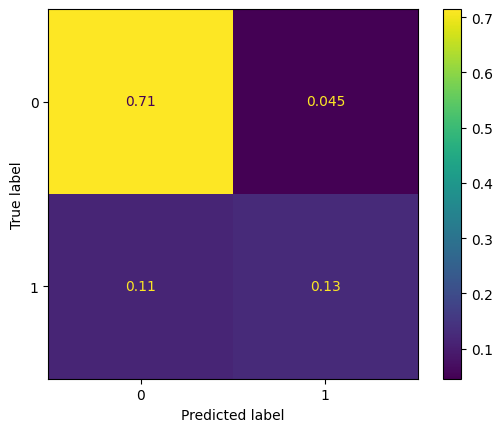

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train, normalize='all')).plot() # procentage, added together adds up to one(100%)
plt.show()

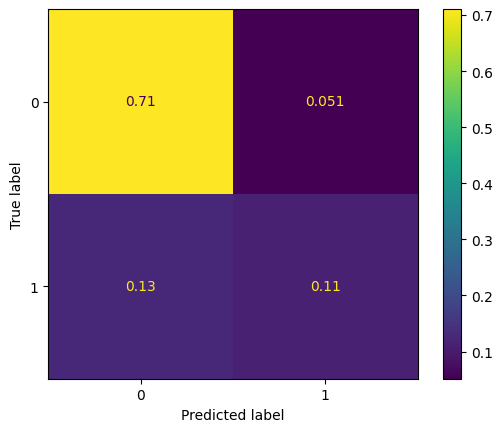

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test, normalize='all')).plot()
plt.show()

#### 7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)

In [70]:
X_test_female = X_test[X_test["sex_Male"] == 0]
X_test_male = X_test[X_test["sex_Male"] == 1]

y_test_female = y_test[X_test["sex_Male"] == 0]
y_test_male = y_test[X_test["sex_Male"] == 1]


In [ ]:
y_female_pred_test = xgb_model.predict(X_test_female)
y_male_pred_test = xgb_model.predict(X_test_male)

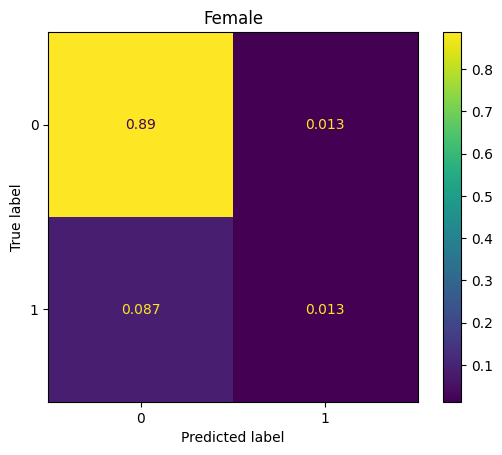

In [78]:
ConfusionMatrixDisplay(confusion_matrix(y_test_female, y_female_pred_test, normalize='all')).plot()
plt.title("Female")
plt.show()

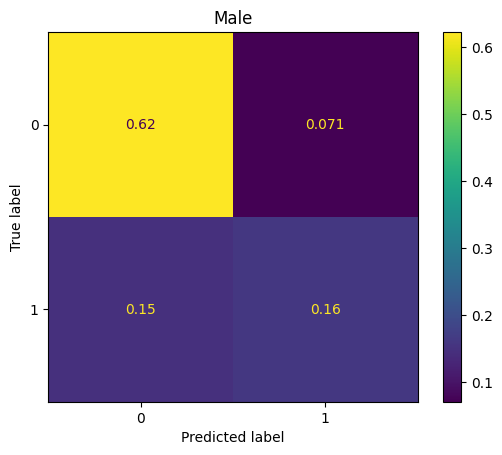

In [79]:
ConfusionMatrixDisplay(confusion_matrix(y_test_male, y_male_pred_test, normalize='all')).plot()
plt.title("Male")
plt.show()

#### 8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.

In [ ]:
print("Female scores: ")
print("train accuracy score:  ", accuracy_score(y_test_female, y_female_pred_test))
print("train Precision score: ", precision_score(y_test_female, y_female_pred_test))
print("train Recall score:    ", recall_score(y_test_female, y_female_pred_test))
print("train f1 score:        ", f1_score(y_test_female, y_female_pred_test))
print("")
print("Male scores: ")
print("test accuracy score:   ", accuracy_score(y_test_male, y_male_pred_test))
print("test Precision score:  ", precision_score(y_test_male, y_male_pred_test))
print("test Recall score:     ", recall_score(y_test_male, y_male_pred_test))
print("test f1 score:         ", f1_score(y_test_male, y_male_pred_test))

Female score: 
train accuracy score:   0.9007004532344458
train Precision score:  0.5080645161290323
train Recall score:     0.13016528925619836
train f1 score:         0.20723684210526316

Male score: 
test accuracy score:    0.7828349831615471
test Precision score:   0.6934984520123839
test Recall score:      0.5221445221445221
test f1 score:          0.5957446808510638


    The accuracy score for female is 0.90 which is greater than the original mode of 0.84. With the female being the greater accuracy, that would mean that the male model is less so with 0.78
    That indicates a greater accuracy of one gender over the other, here the female, and by a measurable amount, not just margin of error.
    Given this is about income, and keep in mind the very simplified categorized income label just above or below 50k, it is easier to predict females income than males.
    
    This should be investigated, is the data skewed, many more of one gender, many more of one income or some other feature that is heavily skewed

#### 9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)

In [110]:
FP_f = sum((y_test_female == 0) & (y_female_pred_test == 1))
FN_f = sum((y_test_female == 0) & (y_female_pred_test == 0))
TP_f = sum((y_test_female == 1) & (y_female_pred_test == 1))
TN_f = sum((y_test_female == 1) & (y_female_pred_test == 0))

FP_m = sum((y_test_male == 0) & (y_male_pred_test == 1))
FN_m = sum((y_test_male == 0) & (y_male_pred_test == 0))
TP_m = sum((y_test_male == 1) & (y_male_pred_test == 1))
TN_m = sum((y_test_male == 1) & (y_male_pred_test == 0))

In [111]:
print("Female scores: ")
print("FP_f: ", FP_f)
print("FN_f: ", FN_f)
print("TP_f: ", TP_f)
print("TN_f: ", TN_f)
print("")
print("Male scores: ")
print("FP_m: ", FP_m)
print("FN_m: ", FN_m)
print("TP_m: ", TP_m)
print("TN_m: ", TN_m)

Female scores: 
FP_f:  61
FN_f:  4309
TP_f:  63
TN_f:  421

Male scores: 
FP_m:  693
FN_m:  6103
TP_m:  1568
TN_m:  1435


##### These values are the same as the ones in the confusion matrix, why we calculateing them?

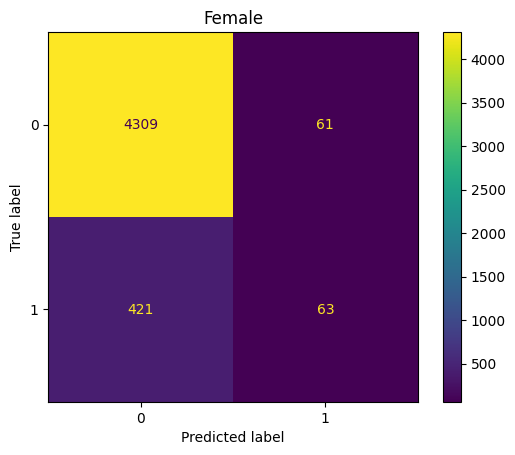

In [88]:
ConfusionMatrixDisplay(confusion_matrix(y_test_female, y_female_pred_test)).plot()
plt.title("Female")
plt.show()

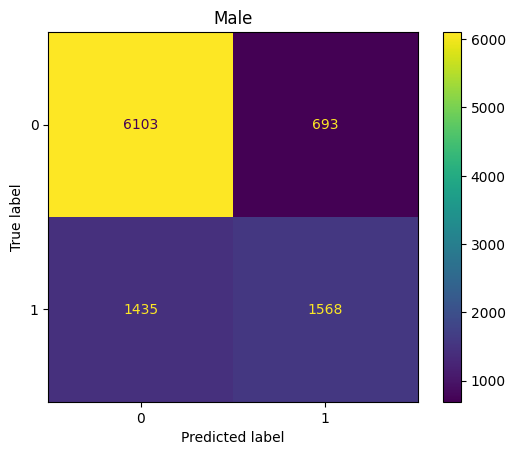

In [89]:
ConfusionMatrixDisplay(confusion_matrix(y_test_male, y_male_pred_test)).plot()
plt.title("Male")
plt.show()

#### 10. Is there error rate balanced across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?

In [113]:
FPR_f = FP_f / (FP_f + TN_f) # false alarm, This is a statistical measure of how often a test incorrectly indicates a positive condition when it is actually negative
FNR_f = FN_f / (FN_f + TP_f) # miss rate

FPR_m = FP_m / (FP_m + TN_m)
FNR_m = FN_m / (FN_m + TP_m)

print("FPR_f", FPR_f)
print("FNR_f", FNR_f)
print("\nFNR_m", FPR_m)
print("FNR_m", FNR_m)

FPR_f 0.12655601659751037
FNR_f 0.9855901189387009

FNR_m 0.3256578947368421
FNR_m 0.7955937948116282


    1 is high income, 0 is low income

    true positive is correctly predicted high income
    true negative is correcly predicted low income

    false positive is incorrectly predicted high income
    false negative is incorrectly predicted low income

    No the error rate is not balanced the same way between genders, where for female the false positive rate is low(0.12) and their false negative rate is very high(0.98)
    indicating it doesn't get many wrong predictions of high income, it does however get many wrong predictions of low income, having a very high miss rate

    For male it is a bit more balanced between false positive and false negative rates, still having that the wrong predictions of low income(miss rate) is higher the the false alarm

#### 11. Is there predictive parity across different genders?

In [112]:
PPV_f = TP_f / (TP_f + FP_f) # PPV: Positive Predictive Value, aka precision
PPV_m = TP_m / (TP_m + FP_m)

print("PPV_f: ", PPV_f)
print("PPV_m: ", PPV_m)

PPV_f:  0.5080645161290323
PPV_m:  0.6934984520123839


    The PPV is higher for male, meaning it is better at predicting accurately the income of males than for females
    The difference is great enough to not just be a margin of error

    There is not predictive oarity across genders

#### 12. Is there Statistical parity across different genders?

In [114]:
y_test_female

20668    0
493      0
41752    0
37749    0
21737    0
        ..
33725    0
46458    0
23581    0
19005    1
469      1
Name: income, Length: 4854, dtype: int64

In [ ]:
Stat_parity_negative_f = (TN_f + FN_f) / len(y_test_female)
Stat_parity_positive_f = (FP_f + TP_f) / len(y_test_female)

Stat_parity_negative_m = (TN_m + FN_m) / len(y_test_male)
Stat_parity_positive_m = (FP_m + TP_m) / len(y_test_male)


print("Stat_parity_negative_f: ", Stat_parity_negative_f)
print("Stat_parity_positive_f: ", Stat_parity_positive_f)

print("\nStat_parity_negative_m: ", Stat_parity_negative_m)
print("Stat_parity_positive_m: ", Stat_parity_positive_m)

Stat_parity_negative_f:  0.9744540585084467
Stat_parity_positive_f:  0.02554594149155336

Stat_parity_negative_m:  0.7692621696091438
Stat_parity_positive_m:  0.2307378303908562


    I dont understand the question
    What is the difference between this question and the previous?

    As seen for female there is a way greater total prediction for low income compared to a very small procentage of predictions of high income
    For male this more balanced than for female, but still a bit skewed towards predicting for high income

#### 13. [Discussion question] Can any of your models be used to make fair salary predictions?

    I would argue no, the data when looking at the confusion matrix, that their is a high degree of skewed data towards low income, and it makes the models make good predictions just choosing the more popular outcome
    At the same time the gender is also skewed quite a bit with way more males in the data set.
    Looking at the accuracy solely you could assume the models works quite well(og: 82, female: 90, male: 78), but together with the other metrics that have way worse scores, the result is that the model fails in other areas
    and that something is up with the model. 

    The best model if one was forced to choose one would be the one for male, that could be better than a coin flip at predicting income 

#### 14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?

    For female a much greater procentage of the data is skewed towards low income, making it biased to predict low income as well

#### 15. [Discussion question] If the dataset is biased, where could the bias potentially come from?

    From a skewed data set of sex and income, many more males in the data and many more low income
    potentionally also other features could be skewed like age, maybe there are more old men with more experience and in comparison there is females in the data with lower age and there fore less work experience
    Possibly also for the hours-per-week, same could be said about all other features, it would be benifical to investigate to ensure lower bias and a more accurate model

#### 16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

    Do this. I would assume it would make a much better model, though might still be measurable biased